# 1. 深层神经网络

In [20]:
import torch
X = torch.tensor([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]], dtype= torch.float32)
andgate = torch.tensor([1, 1, 1, 0], dtype= torch.float32)
def NAND(X):
    w = torch.tensor([0.23, -0.15, -0.15], dtype= torch.float32)
    andhat = torch.mv(X, w)
    yhat = torch.tensor([int(X) for X in andhat >0], dtype= torch.float32)
    return yhat
NAND(X)

tensor([1., 1., 1., 0.])

In [21]:
import torch
X = torch.tensor([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]], dtype= torch.float32)
orgate = torch.tensor([0, 1, 1, 1], dtype= torch.float32)
def OR(X):
    w = torch.tensor([-0.08, 0.15, 0.15], dtype= torch.float32)
    zhat = torch.mv(X, w)
    yhat = torch.tensor([int(X) for X in zhat >0], dtype= torch.float32)
    return yhat
OR(X)

tensor([0., 1., 1., 1.])

![Alt text](image-7.png)

![Alt text](image-8.png)

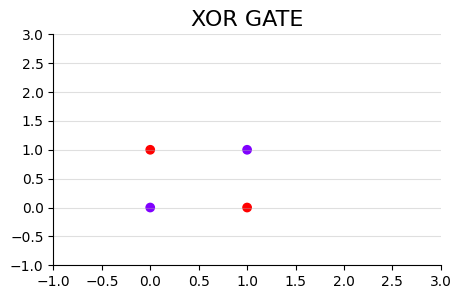

In [29]:
import matplotlib.pyplot as plt

# 定义输入和输出
xorgate = torch.tensor([0, 1, 1, 0], dtype=torch.float32)
X = torch.tensor([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]], dtype=torch.float32)
y_xor = torch.tensor([0, 1, 1, 0])

# 创建一个图形窗口
plt.figure(figsize=(5, 3))

# 设置标题
plt.title("XOR GATE", fontsize=16)

# 绘制散点图
plt.scatter(X[:, 1], X[:, 2], c=y_xor, cmap="rainbow")

# 设置坐标轴范围
plt.xlim(-1, 3)
plt.ylim(-1, 3)

# 绘制网格线
plt.grid(alpha=.4, axis="y")

# 隐藏顶部和右侧的边框
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)

In [22]:
import torch

# 输入层特征
X = torch.tensor([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]], dtype= torch.float32)
sigma_nand = NAND(X)

In [23]:
sigma_or = OR(X)

In [24]:
x0 = torch.tensor([1, 1, 1, 1], dtype= torch.float32)

In [25]:
input_2 = torch.cat((x0.view(4,1), sigma_nand.view(4, 1), sigma_or.view(4, 1)), dim= 1)

In [26]:
def AND(X):
    w = torch.tensor([-0.2, 0.15, 0.15], dtype= torch.float32)
    zhat = torch.mv(X, w)
    andhat = torch.tensor([int(X) for X in zhat >= 0], dtype= torch.float32)
    return andhat

In [27]:
AND(input_2)

tensor([0., 1., 1., 0.])

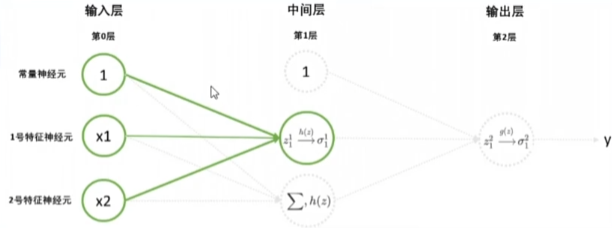

在神经网络中，任意层上都至少有一个神经元，最上面的是常量神经元，连接常量神经元的箭头上的参数是截距b，剩余的是特征神经元，连接这些神经元的箭头上的参数都是权重w。神经元是从上到下进行编号的。和从0开始编号的层数不同，神经元是从1开始编号的。需要注意的是，常量神经元与特征神经元是分别编号的

# 2. 探索深度神经网络

层本身并不是神经网络解决非线性问题的关键，层上的非线性变换h（z）才是。如果h（z）是线性函数，那增加再多层都没用

* 关键概念：激活函数
  在人工神经网络的神经元上，根据一组输入定义该神经元的输出结果的函数，就是激活函数。激活函数一般都是非线性函数，它出现在神经网络中除了输入层以外的每层的每个神经元上

* 输出层的g(z)与隐藏层h（z）激活函数的区别
  1. 虽然都是激活函数，但隐藏层和输出层上的激活函数作用是完全不一样的。输出层的激活函数g(z)是为了让神经网络能够输出不同类型的标签儿存在的。其中恒等函数用于回归，sigmoid函数函数用于二分类，softmax用于多分类。换句话说，g(z)仅仅与输出结果的表现形式有关，与神经网络的效果无关，也因此它可以使用线性的恒等函数。氮隐藏层的激活函数就不同了，隐藏层上的激活函数h(z)的选择会影响神经网络的效果，而线性的h(z)是会让神经网络的结构失效的。

   2. 在同一个神经网络中，g(z)与h（z）可以是不同的，并且在大多数运行回归和多分类的神经网络时，他们也的确是不同的。每层上的h(z)可以是不同的，但是同一层上的激活函数必须一致。

# 3. 从0实现深度神经网络的正向传播

学到这里，我们已经学完了一个普通深度神经网络全部的基本元素————用来构筑神经网络的结构的层与激活函数，输入神经网络的数据（特征， 权重， 截距），并且我们了解从左向右的过程是神经网络的正向传播（也叫做前向传播，或者向前传播）。

假设我们有500条数据，20个特诊，标签为3分类。我们现在要实现一个三层神经网络，这个神经网络的架构如下：第一层有13个神经元，第二层有8个神经元，第三层是输出层。其中，第一层的激活函数是relu，第二层是sigmoid。我们要如何实现它呢？


In [30]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# 确定数据
torch.random.manual_seed(420)
x = torch.rand((500, 20), dtype= torch.float32)
y = torch.randint(low= 0, high= 3, size=(500, 1), dtype= torch.float32)

class Model(nn.Module):
    def __init__(self, in_features = 10, out_features = 2):
        """ 
        in_feautres :输入该神经网络的特诊数目（输入层上神经元的数目）
        out_features :神经网络的输出的数目（输出层上神经元的数目）
        """
        super(Model, self).__init__()
        self.linear1 = nn.Linear(in_features, 13, bias=  True)
        self.linear2 = nn.Linear(13, 8, bias=True)
        self.linear3 = nn.Linear(8, out_features, bias= True)
    
    def forward(self, x):   # 神经网络的向前传播
        z1 = self.linear1(x)
        sigma1 = torch.relu(z1)
        z2 = self.linear2(sigma1)
        sigma2 = torch.sigmoid(z2)
        z3 = self.linear3(sigma2)
        yhat = F.softmax(z3, dim= 1)
        return yhat

input_1 = x.shape[1]
output_ = len(y.unique())

# 实例化神经网络
torch.random.manual_seed(420)
net = Model(in_features= input_1, out_features= output_)
net.forward(x)

tensor([[0.4140, 0.3496, 0.2365],
        [0.4210, 0.3454, 0.2336],
        [0.4011, 0.3635, 0.2355],
        ...,
        [0.4196, 0.3452, 0.2352],
        [0.4153, 0.3455, 0.2392],
        [0.4153, 0.3442, 0.2405]], grad_fn=<SoftmaxBackward0>)

In [33]:
net.linear1.weight.shape

torch.Size([13, 20])

In [34]:
net.linear2.weight.shape

torch.Size([8, 13])

In [35]:
net.linear3.weight.shape

torch.Size([3, 8])

In [37]:
net.cpu()

Model(
  (linear1): Linear(in_features=20, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=3, bias=True)
)

In [38]:
net.cuda    # 将整个网络转移到GPU上运行

<bound method Module.cuda of Model(
  (linear1): Linear(in_features=20, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=3, bias=True)
)>

In [ ]:
net.apply()     # 对神经网络中所有层，init函数中所有对象都执行同样的操作